In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers import ELU, PReLU, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Specify the data size

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

Generator Network

In [4]:
def generator(img_shape, z_dim):

    model = Sequential()

    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

Discriminator Network

In [5]:
def discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [6]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

GAN Training function

In [7]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):

    # Load the dataset
    #path = "C:\\Users\\hgani\\Desktop\\CARLIFE DATA\\carlife_all_data\\Carlife_jpg"
    #X_train = cv2.imread(path + '\\'+ str(i) for i in os.listdir(path))
    (X_train, _), (_, _) = mnist.load_data()
    data_slice = 3000
    X_train = X_train[:data_slice,:]
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:

            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples
            sample_images(iteration)

In [8]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1,
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5


    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                                    figsize=(4,4), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [9]:
import warnings; warnings.simplefilter('ignore')

GAN Training

4/4 [==============================] - 0s 2ms/step
0 [D loss: 0.083336, acc.: 98.05%] [G loss: 4.823174]
4/4 [==============================] - 0s 2ms/step
10 [D loss: 0.031041, acc.: 99.61%] [G loss: 4.892765]
4/4 [==============================] - 0s 2ms/step


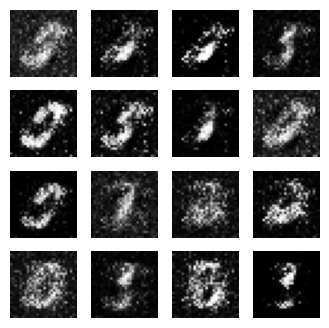

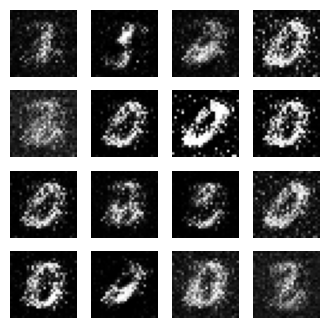

In [11]:
iterations = 20
batch_size = 128
sample_interval = 10

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)